# LSTM Stock Predictor Using Closing Prices

In this notebook, We will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin closing prices to predict the 11th day closing price. 

we will execute the following steps:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, We will prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

Steps:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [36]:
import numpy as np
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt
import hvplot.pandas

In [37]:
# # Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
# from numpy.random import seed
# seed(1)
# from tensorflow import random
# random.set_seed(2)

In [38]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('Resources/btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [39]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('Resources/btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [40]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [41]:
#let's create a daily returns/percentage change in closing prices column. This column can be used to run the model and predict the 
#daily returns instead of predicting the close prices. 
#just change the feature column and target column index to Returns index and the entire model works just the same way
df['Returns'] = df['Close'].pct_change()

In [42]:
df.Returns.fillna(0, inplace=True)
df.head()

,fng_value,Close,Returns
2018-02-01,30,9114.719727,0.000000
2018-02-02,15,8870.820313,-0.026759
2018-02-03,40,9251.269531,0.042888
2018-02-04,24,8218.049805,-0.111684
2018-02-05,11,6937.080078,-0.155873


In [43]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [44]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10
feature_column = 1   # 'Close' column
target_column = 1    # `Close` column
X, y = window_data(df, window_size, feature_column, target_column)

In [45]:
# Use 70% of the data for training and the remaineder for testing
split=int(0.7*len(X))
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

In [46]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler=MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [47]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [48]:
print (f"X_train sample values:\n{X_train[:1]} \n")
print (f"X_test sample values:\n{X_test[:1]}")

X_train sample values:
[[[0.60761794]
  [0.58242373]
  [0.62172321]
  [0.51499412]
  [0.38267307]
  [0.46160996]
  [0.4503991 ]
  [0.5193988 ]
  [0.56445096]
  [0.55127638]]] 

X_test sample values:
[[[0.04675556]
  [0.03913222]
  [0.03975922]
  [0.03856719]
  [0.03679562]
  [0.03728835]
  [0.03974167]
  [0.04528668]
  [0.04528668]
  [0.07024855]]]


---

## Build and Train the LSTM RNN

In this section, lets design a custom LSTM RNN and fit (train) it using the training data.

Steps:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [15]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()
num_units= 30 
dropout_fraction = 0.2
#first LSTM layer
model.add(LSTM(units=num_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_fraction))
#2nd LSTM layer
model.add(LSTM(units=num_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
#3rd LSTM layer
model.add(LSTM(units=num_units))
model.add(Dropout(dropout_fraction))
#output layer
model.add(Dense(1))

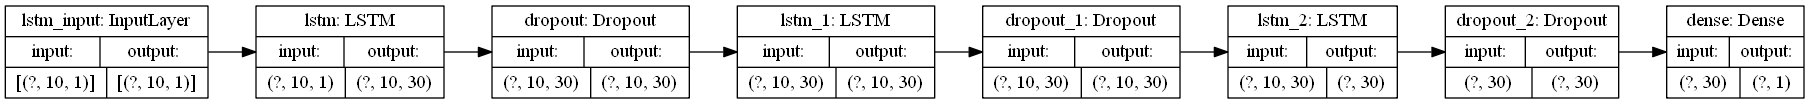

In [16]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# visualize the model architecture.
tf.keras.utils.plot_model(model, to_file='Resources/btc.png', show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=True, dpi=96)

In [17]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 10, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [18]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiment with the batch size, but a smaller batch size is recommended
# we can play with batch size parameter, but given a small data set, we can go with batch size of 1.
model.fit(X_train, y_train, batch_size=1, epochs=10, shuffle=False, verbose=1)

Epoch 1/10
372/372 [==============================] - 9s 23ms/step - loss: 0.0198
Epoch 2/10
372/372 [==============================] - 8s 22ms/step - loss: 0.0171
Epoch 3/10
372/372 [==============================] - 9s 23ms/step - loss: 0.0239
Epoch 4/10
372/372 [==============================] - 8s 21ms/step - loss: 0.0236
Epoch 5/10
372/372 [==============================] - 8s 22ms/step - loss: 0.0218
Epoch 6/10
372/372 [==============================] - 8s 22ms/step - loss: 0.0180
Epoch 7/10
372/372 [==============================] - 8s 23ms/step - loss: 0.0145
Epoch 8/10
372/372 [==============================] - 8s 21ms/step - loss: 0.0141
Epoch 9/10
372/372 [==============================] - 8s 23ms/step - loss: 0.0127
Epoch 10/10
372/372 [==============================] - 9s 23ms/step - loss: 0.0121


---

## Model Performance

In this section, you will evaluate the model using the test data.
You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

We will apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [19]:
# Evaluate the model
model.evaluate(X_test, y_test, batch_size=2, verbose=1)

80/80 [==============================] - 1s 8ms/step - loss: 0.0559


0.055941201746463776

In [20]:
# Make some predictions
predicted=model.predict(X_test)

In [21]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [22]:
# Create a DataFrame of Real and Predicted values
btc_df = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
btc_df.head()

,Real,Predicted
2019-02-20,3924.239990,3860.780518
2019-02-21,3974.050049,3892.472656
2019-02-22,3937.040039,3930.397217
2019-02-23,3983.530029,3965.113770
2019-02-24,4149.089844,3995.179443


In [23]:
# Plot the real vs predicted values as a line chart
fig, ax = plt.subplots()
ax.plot(btc_df)
plt.title(str(window_size) + 'day window of Bitcoin close prices')
filename='Resources/close_'+ f'{window_size}' + 'day.png'
fig.savefig(filename)
plt.close(fig)

### Analysis:
The model performed well in terms of the direction in predicting the closing prices based on the last 10 day close prices. 
While the predicted direction was satisfactory, the magnitude of the predicted prices is not quite as good compared to real prices.
After experimenting with changing the batch size, epochs or units in LSTM layer or even removing the dropout layers, 
the performance of the model did not improve significantly.

The model performed better when reducing the time window to 2 days compared to 10-day or 5-day windows.